In [1]:
import pandas as pd    
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
# constants
stopwords_file = 'Stopwords.txt'
db_name = 'sqlite:///StaterData.db'
table_name = "mortgage complaints"

In [3]:
# get stopwords
with open(stopwords_file, 'r') as f:
    stop_words = f.read().splitlines()

In [4]:
# get sqlite database via sqlalchemy
db = sqlalchemy.create_engine(db_name)

# get data from table
data = pd.read_sql_table(table_name, db)

In [5]:
# create DataFrame
df = pd.DataFrame(data)
df.head()

,index,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4,2023-01-16,Mortgage,Conventional home mortgage,Struggling to pay mortgage,None,I have been dealing with Select Portfolio Serv...,Company believes it acted appropriately as aut...,"SELECT PORTFOLIO SERVICING, INC.",IN,463XX,None,True,Web,2023-01-16,Closed with explanation,True,True,6440191
1,6,2023-01-15,Mortgage,FHA mortgage,Applying for a mortgage or refinancing an exis...,None,I am unable to obtain a standard loan estimate...,None,Fairway Independent Mortgage Corporation,NY,11207,None,True,Web,2023-01-16,Closed with explanation,True,True,6440122
2,10,2023-01-16,Mortgage,VA mortgage,Closing on a mortgage,None,"CFPB\t\tComplaint by XXXX, XXXX XXXX, & wife X...",Company believes it acted appropriately as aut...,Village Capital & Investment LLC,ID,838XX,Servicemember,True,Web,2023-02-06,Closed with explanation,True,True,6442766
3,11,2021-11-02,Mortgage,VA mortgage,Trouble during payment process,None,Purpose : Out of forbearance to refinance with...,None,"Caliber Home Loans, Inc.",WA,98038,Servicemember,True,Web,2021-11-02,Closed with explanation,True,True,4868722
4,12,2019-01-29,Mortgage,Other type of mortgage,Trouble during payment process,None,This is the second part of the issue with this...,None,NATIONSTAR MORTGAGE LLC,NM,870XX,None,True,Web,2019-01-29,Closed with explanation,True,True,3136715


In [6]:
# set Issue as category
df['Issue'] = df['Issue'].astype('category')

In [7]:
extracted_df = df[['Consumer complaint narrative', 'Issue']].copy()

x = extracted_df['Consumer complaint narrative']
y = extracted_df['Issue']

# get all categories for visualisation
cat_issue = y.cat.categories

In [8]:
# split data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2)

In [9]:
# use One-Hot Encoding as 'Issue' is a nominal categoric variable
def get_cat_array(list):
    array_cat = []
    for item in list:
        array_cat.append([item])
    return array_cat

# encoder will return an array instead of matrix
encoder = OneHotEncoder(sparse=False)
# encoder.categories_ 

y_train_encoded = encoder.fit_transform(get_cat_array(y_train.cat.categories))
y_test_encoded = encoder.fit_transform(get_cat_array(y_test.cat.categories))

saga and sag are solvers to use for multinomial logistic regression.
Both supports multinomial logistic regressions. more information: https://scikit-learn.org/stable/modules/linear_model.html#solvers
In this case the solver is sag as it is better in performance. However, saga is a variant of sag and supports more penalties than sag.  

In [10]:
# text to numbers
vect = CountVectorizer(stop_words=stop_words)
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [18]:
logregression = LogisticRegression(n_jobs=4, solver='sag', multi_class='multinomial')

In [19]:
logregression.fit(X_train, y_train)
logregression.score(X_test, y_test)

C:\Users\Cindy\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.5614567042226549

In [13]:
y_pred = logregression.predict(X_test)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=cat_issue, index=cat_issue)
cm = (cm.transpose()/cm.sum(axis=1)).transpose()

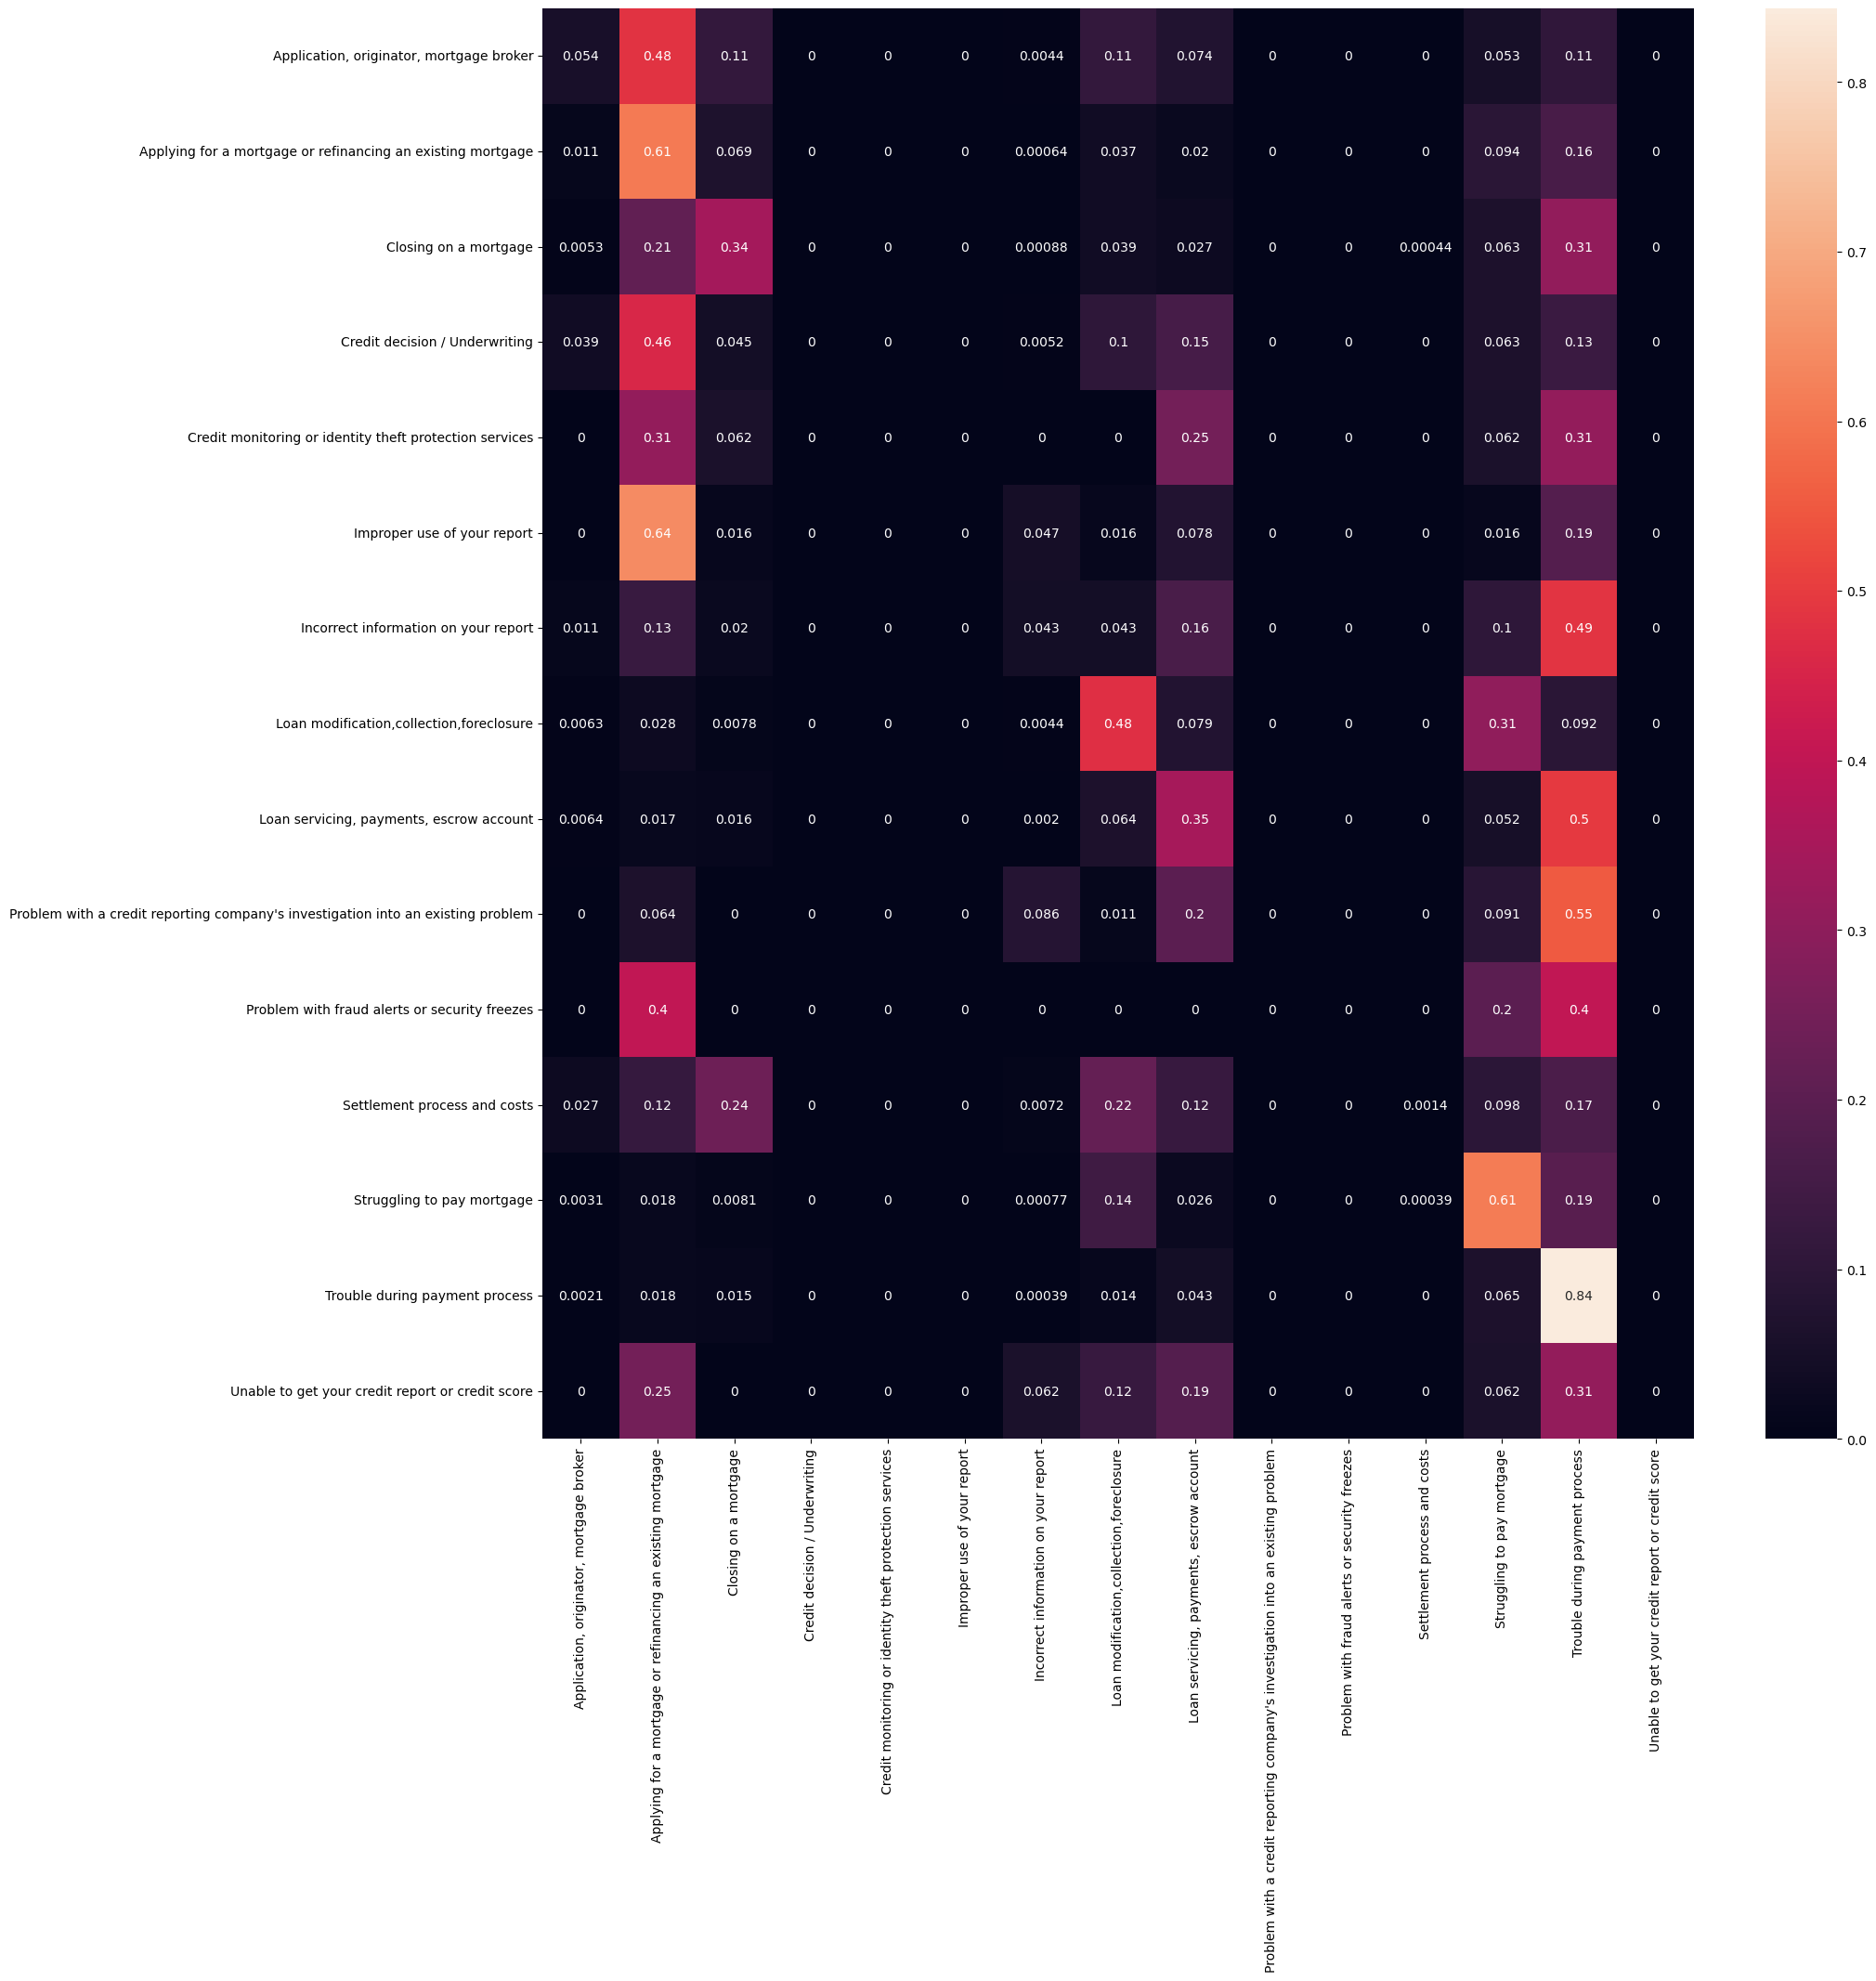

In [14]:
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True)
plt.show()

In [15]:
print(classification_report(y_test, y_pred, target_names=cat_issue))

C:\Users\Cindy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                                  precision    recall  f1-score   support

                                        Application, originator, mortgage broker       0.27      0.05      0.09      1139
                     Applying for a mortgage or refinancing an existing mortgage       0.51      0.61      0.55      3125
                                                           Closing on a mortgage       0.49      0.34      0.40      2281
                                                  Credit decision / Underwriting       0.00      0.00      0.00       381
                         Credit monitoring or identity theft protection services       0.00      0.00      0.00        16
                                                     Improper use of your report       0.00      0.00      0.00        64
                                            Incorrect information on your report       0.22      0.04      0.07       440
                       

C:\Users\Cindy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cindy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
